# G/SG Morph `pyqubo_form` module examples

## Graph Isomorphism

In [1]:
import gsgmorph.pyqubo_form as gsgm_pqf
import networkx as nx

In [2]:
graph_to_embed = nx.Graph([(1,2),(1,3),(2,3),(2,4),(4,5),(5,3)])
target_graph = nx.Graph([('a','b'),('a','c'),('b', 'c'), ('b', 'd'), ('d', 'e'), ('e', 'c')])

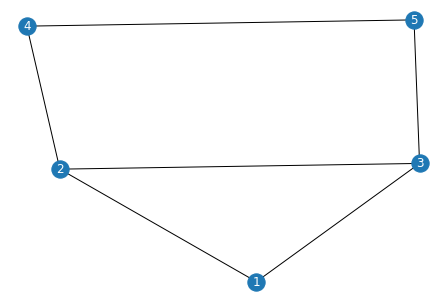

In [3]:
# Get fixed position
pos = nx.spring_layout(graph_to_embed, seed=9999)

# Graph to be embedded onto a target graph
nx.draw(graph_to_embed, pos, with_labels=True, font_color='w')

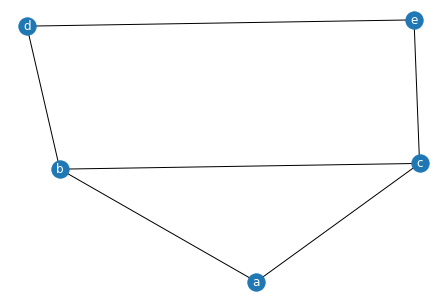

In [4]:
# Get fixed position
pos = nx.spring_layout(target_graph, seed=9999)

# Target graph, the above graph will be mapped to this one
nx.draw(target_graph, pos, with_labels=True, font_color='w')

In [5]:
# get the pyQUBO expression and translation dictionary which allows us
# to translate from the annealer results to the actual node mapping
pyqubo_exp, sample_translation_dict = gsgm_pqf.graph_isomorphism(graph_to_embed, target_graph)

In [6]:
# Code for this section taken from: 
# https://pyqubo.readthedocs.io/en/latest/#integration-with-d-wave-ocean
import neal

# Initiate annealer
sampler = neal.SimulatedAnnealingSampler()

# Convert the PyQUBO expression to a BQM that can be fed to the annealer
model = pyqubo_exp.compile()
bqm = model.to_bqm()

# Obtain samples from annealing and choose the one with the lowest energy
# Keep in mind that there may exist multiple satisfactory, low-energy solutions!
sampleset = sampler.sample(bqm, num_reads=100)
decoded_samples = model.decode_sampleset(sampleset)
best_sample=min(decoded_samples, key=lambda x: x.energy)

In [7]:
# We can use the PyQUBO-translated annealing sample and the sample translation dictionary
# from before to generate a dictionary that maps nodes from the graph to be embedded to the
# target graph
gsgm_pqf.translate_sample(best_sample, sample_translation_dict)

{4: 'e', 1: 'a', 2: 'c', 5: 'd', 3: 'b'}

## Subgraph Ismorophism

In [8]:
import gsgmorph.pyqubo_form as gsgm_pqf
import networkx as nx

In [9]:
target_graph = nx.Graph([('a','c'),('c','b'),('a','b'),('a','e'),('e','b')])
graph_to_embed = nx.cycle_graph(3)

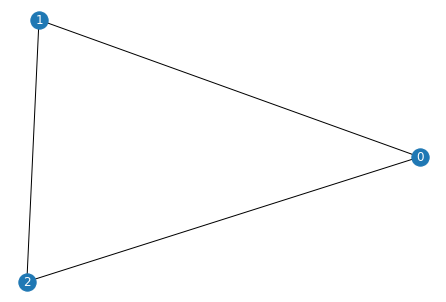

In [10]:
# Get fixed position
pos = nx.spring_layout(graph_to_embed, seed=9999)

# Graph to be embedded onto a target graph
nx.draw(graph_to_embed, pos, with_labels=True, font_color='w')

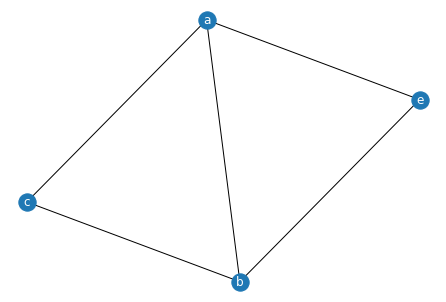

In [11]:
# Get fixed position
pos = nx.spring_layout(target_graph, seed=9999)

# Target graph, the above graph will be mapped to this one
nx.draw(target_graph, pos, with_labels=True, font_color='w')

In [12]:
# get the pyQUBO expression and translation dictionary which allows us
# to translate from the annealer results to the actual node mapping
pyqubo_exp, sample_translation_dict = gsgm_pqf.subgraph_isomorphism(graph_to_embed, target_graph)

In [13]:
# Code for this section taken from: 
# https://pyqubo.readthedocs.io/en/latest/#integration-with-d-wave-ocean
import neal

# Initiate annealer
sampler = neal.SimulatedAnnealingSampler()

# Convert the PyQUBO expression to a BQM that can be fed to the annealer
model = pyqubo_exp.compile()
bqm = model.to_bqm()

# Obtain samples from annealing and choose the one with the lowest energy
# Keep in mind that there may exist multiple satisfactory, low-energy solutions!
sampleset = sampler.sample(bqm, num_reads=100)
decoded_samples = model.decode_sampleset(sampleset)
best_sample=min(decoded_samples, key=lambda x: x.energy)

In [14]:
# We can use the PyQUBO-translated annealing sample and the sample translation dictionary
# from before to generate a dictionary that maps nodes from the graph to be embedded to the
# target graph
mapping = gsgm_pqf.translate_sample(best_sample, sample_translation_dict)

In [15]:
mapping

{1: 'b', 2: 'a', 0: 'e'}

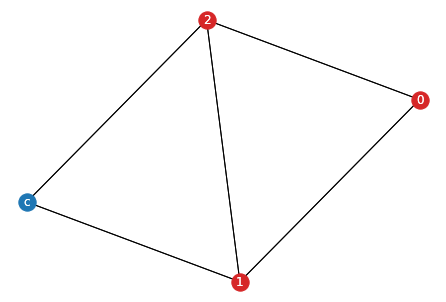

In [16]:
# We can use NetworkX to help us visualize the subgraph and how it maps to the target graph

# Invert the mapping so it is from the target graph TO the graph to embed nodes
# Snippet taken from: 
# https://stackoverflow.com/questions/483666/reverse-invert-a-dictionary-mapping
inv_mapping = {v: k for k, v in mapping.items()}

# relabel the nodes in the target graph with the node labels from the graph to embed
updated_nodes = nx.relabel_nodes(target_graph, inv_mapping, copy=True)
# Get the same fixed position used before
pos = nx.spring_layout(updated_nodes, seed=9999)

# Highlight the nodes that have been relabeled
nx.draw(updated_nodes, pos, with_labels=True, 
        font_color='w', 
        nodelist=[key for key in mapping.keys()], 
        node_color="tab:red")

# Difference between two lists:
# https://stackoverflow.com/questions/3462143/get-difference-between-two-lists
nx.draw(updated_nodes, 
        pos, 
        with_labels=True, 
        font_color='w', 
        nodelist=list(set(updated_nodes.nodes()) - set(mapping.keys())), 
        node_color="tab:blue")

## Induced Subgraph Isomorphism

In [17]:
import gsgmorph.pyqubo_form as gsgm_pqf
import networkx as nx

In [18]:
# graphs obtained from Mccreesh et al.'s "When Subgraph Isomorphism is Really Hard, and Why This Matters for Graph Databases"
# Obtained from: https://hal.archives-ouvertes.fr/hal-01741928/document

# cycle graph with three nodes, along with an additional node
graph_to_embed = nx.cycle_graph(3)
graph_to_embed.add_edge(2,3)

# grip graph modified to format in the above paper
target_graph = nx.grid_graph(dim=[3,3])
target_graph.remove_edges_from([((1,0),(1,1)),((1,1),(1,2))])
target_graph.add_edges_from([((0,1),(1,2)),((1,1),(2,2)),((0,2),(2,2))])

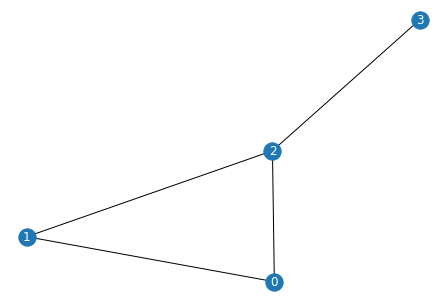

In [19]:
# get fixed position
pos = nx.spring_layout(graph_to_embed, seed=9999)

# target graph
nx.draw(graph_to_embed, pos, with_labels=True, font_color='w')

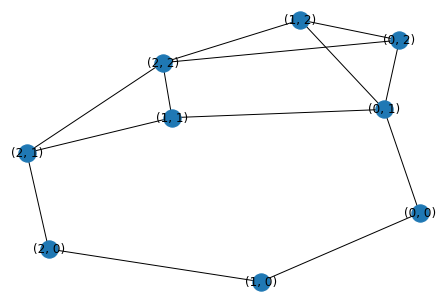

In [20]:
# get fixed position
pos = nx.spring_layout(target_graph, seed=9999)

# target graph
nx.draw(target_graph, pos, with_labels=True)

In [21]:
# get the pyQUBO expression and translation dictionary which allows us
# to translate from the annealer results to the actual node mapping

# NOTE that the "induced" argument is set ot True, indicating that a QUBO for the induced sugraph isomorphism is to be generated.
# by default, it is set to False and the user does not need to change anything (see the normal subgraph isomoprhism demo above)
pyqubo_exp, sample_translation_dict = gsgm_pqf.subgraph_isomorphism(graph_to_embed, target_graph, induced=True)

In [22]:
# Code for this section taken from: 
# https://pyqubo.readthedocs.io/en/latest/#integration-with-d-wave-ocean
import neal

# Initiate annealer
sampler = neal.SimulatedAnnealingSampler()

# Convert the PyQUBO expression to a BQM that can be fed to the annealer
model = pyqubo_exp.compile()
bqm = model.to_bqm()

# Obtain samples from annealing and choose the one with the lowest energy
# Keep in mind that there may exist multiple satisfactory, low-energy solutions!
sampleset = sampler.sample(bqm, num_reads=100)
decoded_samples = model.decode_sampleset(sampleset)
best_sample=min(decoded_samples, key=lambda x: x.energy)

In [23]:
# We can use the PyQUBO-translated annealing sample and the sample translation dictionary
# from before to generate a dictionary that maps nodes from the graph to be embedded to the
# target graph
mapping = gsgm_pqf.translate_sample(best_sample, sample_translation_dict)

In [24]:
mapping

{1: (1, 1), 2: (2, 1), 0: (2, 2), 3: (2, 0)}

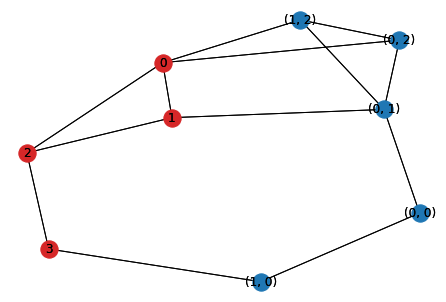

In [25]:
# We can use NetworkX to help us visualize the subgraph and how it maps to the target graph

# Invert the mapping so it is from the target graph TO the graph to embed nodes
# Snippet taken from: 
# https://stackoverflow.com/questions/483666/reverse-invert-a-dictionary-mapping
inv_mapping = {v: k for k, v in mapping.items()}

# relabel the nodes in the target graph with the node labels from the graph to embed
updated_nodes = nx.relabel_nodes(target_graph, inv_mapping, copy=True)
# Get the same fixed position used before
pos = nx.spring_layout(updated_nodes, seed=9999)

# Highlight the nodes that have been relabeled
nx.draw(updated_nodes, pos, with_labels=True, 
        nodelist=[key for key in mapping.keys()], 
        node_color="tab:red")

# Difference between two lists:
# https://stackoverflow.com/questions/3462143/get-difference-between-two-lists
nx.draw(updated_nodes, 
        pos,
        with_labels=True, 
        nodelist=list(set(updated_nodes.nodes()) - set(mapping.keys())), 
        node_color="tab:blue")